# Image Classification with CIFAR-10 dataset
In this notebook, I am going to classify images from the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).  The dataset consists of airplanes, dogs, cats, and other objects. You'll preprocess the images, then train a convolutional neural network on all the samples. The images need to be normalized and the labels need to be one-hot encoded. Some more interesting datasets can be found [here](http://rodrigob.github.io/are_we_there_yet/build/#datasets)

Some of the code and description of this notebook is borrowed by [this repo](https://github.com/udacity/deep-learning/tree/master/image-classification) provided by Udacity's Deep Learning Nanodegree program. This notebook has been reproduced decorated with richer descriptions after completing the Udacity's project.

## Get the Data
Run the following cell to download the [CIFAR-10 dataset for python](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Some references to look up
- [CIFAR-10/CIFAR-100 dataset](https://www.cs.toronto.edu/~kriz/cifar.html): labeled subsets of the 80 million tiny images dataset. 
- [urlretrieve lib](https://docs.python.org/3.0/library/urllib.request.html): copy a network object denoted by a URL to a local file, if necessary
- [tarfile lib](https://docs.python.org/2/library/tarfile.html): makes it possible to read and write tar archives, including those using gzip or bz2 compression.
- [tqdm lib](https://pypi.python.org/pypi/tqdm): Fast, Extensible Progress Meter

In [55]:
!pip install tensorflow==1.14

     |████████████████████████████████| 109.2MB 32kB/s 
     |████████████████████████████████| 3.2MB 38.0MB/s 
     |████████████████████████████████| 51kB 5.5MB/s 
     |████████████████████████████████| 491kB 49.3MB/s 
  Found existing installation: tensorboard 2.4.0
    Uninstalling tensorboard-2.4.0:
      Successfully uninstalled tensorboard-2.4.0
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorflow 2.4.0
    Uninstalling tensorflow-2.4.0:
      Successfully uninstalled tensorflow-2.4.0


In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm 
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

class DownloadProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

""" 
    check if the data (zip) file is already downloaded
    if not, download it from "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz" and save as cifar-10-python.tar.gz
"""
if not isfile('cifar-10-python.tar.gz'):
    with DownloadProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            'cifar-10-python.tar.gz',
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()


## Before Jumping in

### Some references to look up
- [python pickle](https://docs.python.org/3/library/pickle.html): implements binary protocols for serializing and de-serializing a Python object structure.
- [numpy reshape](https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html): Gives a new shape to an array without changing its data.
- [numpy transpose](https://docs.scipy.org/doc/numpy/reference/generated/numpy.transpose.html): Permute the dimensions of an array.
- [numpy transpose with list of axes explanation](https://stackoverflow.com/questions/32034237/how-does-numpys-transpose-method-permute-the-axes-of-an-array)
- [tensorflow conv2d](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d): check out input with the argument, data_format. "NHWC": [batch, height, width, channels], "NCHW": [batch, channels, height, width].
- [row major order explanation](https://en.wikipedia.org/wiki/Row-_and_column-major_order)

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

### List of files 

![](./list_of_batch_files.png)

As seen above picture, the dataset is broken into batches to **prevent** your machine from running **out of memory**. The CIFAR-10 dataset consists of 5 batches, named `data_batch_1`, `data_batch_2`, etc..


### Understanding the original data 

The original a batch data is (10000 x 3072) dimensional tensor expressed in numpy array, where the number of columns, (10000), indicates the number of sample data. As stated in the [CIFAR-10/CIFAR-100 dataset](https://www.cs.toronto.edu/~kriz/cifar.html), the row vector, (3072) represents an color image of 32x32 pixels. Since this project is going to use CNN for the classification tasks, the row vector, (3072), is not an appropriate form of image data to feed. In order to feed an image data into a CNN model, the dimension of the tensor representing an image data should be either (width x height x num_channel) or (num_channel x width x height). It depends on your choice (check out the [tensorflow conv2d](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d)). In this particular project, I am going to use the dimension of the first choice because the default choice in tensorflow's CNN operation is so.

[O] need to be modified into a new shape

### Understanding the original labels

The label data is just a list of 10000 numbers in the range 0-9, which corresponds to each of the 10 classes in CIFAR-10. 

* **airplane**
* **automobile**
* **bird**
* **cat**
* **deer**
* **dog**
* **frog**
* **horse**
* **ship**
* **truck**

[X] need to be modified into a new shape


In [3]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [4]:
def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

### How to reshape into a such form?

The row vector (3072) has the exact same number of elements if you calculate 32\*32\*3==3072. In order to reshape the row vector, (3072), there are two steps required. The **first** step is involved with using **reshape** function in numpy, and the **second** step is involved with using **transpose** function in numpy as well.

By definition from the official web site, **reshape** function gives a new shape to an array without changing its data. Here, the phrase **without changing its data** is an important part. **reshape** operations should be delivered in three more detailed step. The following direction is described in a logical concept. 

1. divide the row vector (3072) into 3 pieces. Each piece corresponds to the each channels.
  - this results in (3 x 1024) dimension of tensor
2. divide the resulting tensor from the previous step with 32. 32 here means width of an image.
  - this results in (3 x 32 x 32)

In order to implement the directions written in logical sense in numpy, **reshape** function should be called in the following arguments, (10000, 3, 32, 32). As you noticed, reshape function doesn't automatically divide further when the third value (32, width) is provided. We need to explicitly specify the value for the last value (32, height)


This is not the end of story. Now, the image data is represented as (num_channel, width, height) form. However, **this is not the shape tensorflow and matplotlib are expecting**. They are expecting different shape of (width, height, num_channel) instead. We need to swap the order of each axes, and that is where **transpose** function comes in.

The **transpose** function can take a list of axes, and each value specifies where it wants to move around. For example, calling transpose with argument (1, 2, 0) in an numpy array of (num_channel, width, height) will return a new numpy array of (width, height, num_channel).

<img src="./reshape-transpose.png" alt="Drawing" style="width: 800px;"/>

In [5]:
def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        # note the encoding type is 'latin1'
        batch = pickle.load(file, encoding='latin1')
        
    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']
        
    return features, labels

## Explore the Data

Understanding a dataset is part of making predictions on the data.  Play around with the code cell below by changing the `batch_id` and `sample_id`. The `batch_id` is the id for a batch (1-5). The `sample_id` is the id for a image and label pair in the batch.

The display_stats defined below answers some of questions like in a given batch of data..
- "What are all possible labels?"
- "What is the range of values for the image data?"
- "Are the labels in order or random?"


In [6]:
def display_stats(cifar10_dataset_folder_path, batch_id, sample_id):
    features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_id)
    
    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'.format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch #{}:'.format(batch_id))
    print('# of Samples: {}\n'.format(len(features)))
    
    label_names = load_label_names()
    label_counts = dict(zip(*np.unique(labels, return_counts=True)))
    for key, value in label_counts.items():
        print('Label Counts of [{}]({}) : {}'.format(key, label_names[key].upper(), value))
    
    sample_image = features[sample_id]
    sample_label = labels[sample_id]
    
    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    
    plt.imshow(sample_image)


Stats of batch #3:
# of Samples: 10000

Label Counts of [0](AIRPLANE) : 994
Label Counts of [1](AUTOMOBILE) : 1042
Label Counts of [2](BIRD) : 965
Label Counts of [3](CAT) : 997
Label Counts of [4](DEER) : 990
Label Counts of [5](DOG) : 1029
Label Counts of [6](FROG) : 978
Label Counts of [7](HORSE) : 1015
Label Counts of [8](SHIP) : 961
Label Counts of [9](TRUCK) : 1029

Example of Image 7000:
Image - Min Value: 24 Max Value: 252
Image - Shape: (32, 32, 3)
Label - Label Id: 0 Name: airplane


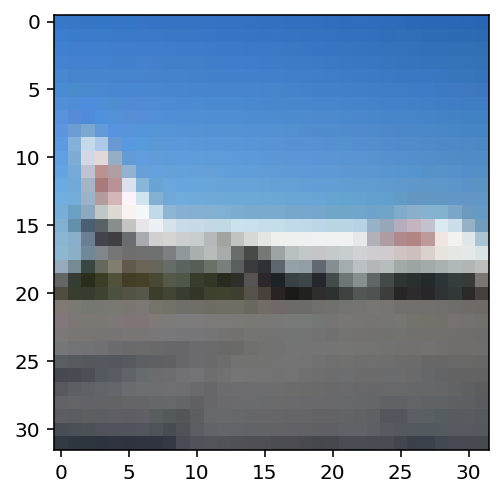

In [7]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

# Explore the dataset
batch_id = 3
sample_id = 7000
display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

## Implement Preprocess Functions
### Normalize
**Min-Max Normalization**
- this simply makes all x values to range between 0 and 1.
- y = (x-min) / (max-min)

**Some references to look up**
- [Min-Max Normalization](https://www.quora.com/What-is-the-meaning-of-min-max-normalization)
- [Watch "why normalizing inputs" / deeplearning.ai - Andrew Ng.](https://www.youtube.com/watch?v=FDCfw-YqWTE)
- [Exploding, Vainishing Gradient descent / deeplearning.ai - Andrew Ng.](https://www.youtube.com/watch?v=qhXZsFVxGKo)

`normalize` function takes an image data, `x`, and returns it as a normalized Numpy array. The values in the original data is going to be transformed in range of 0 to 1, inclusive without change the shape of the array. A simply answer to why normalization should be performed is somewhat related to activation function.

For example, sigmoid activation function takes an input value and outputs a new value ranging from 0 to 1. When the input value is somewhat large, the output value easily reaches the max value 1. Similarily, when the input value is somewhat small, the output value easily reaches the max value 0. 

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/480px-Logistic-curve.svg.png" alt="Drawing" style="width: 300px;"/>

For another example, ReLU activation function takes an input value and outputs a new value ranging from 0 to infinity. When the input value is somewhat large, the output value increases linearly. However, when the input value is somewhat small, the output value easily reaches the max value 0. 

<img src="https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/image_folder_4/Relu.jpeg" alt="Drawing" style="width: 300px;"/>

Now, when we think about the image data, all values originally ranges from 0 to 255. This sounds like when it is passed into sigmoid function, the output is almost always 1, and when it is passed into ReLu function, the output could be very huge. When backpropagation process is performed to optimize the networks, this could lead to an exploding gradient which leads to an aweful learning steps. In order to avoid this issue, ideally, it is better let all the values be around 0 and 1.

In [8]:
def normalize(x):
    """
        argument
            - x: input image data in numpy array [32, 32, 3]
        return
            - normalized x 
    """
    min_val = np.min(x)
    max_val = np.max(x)
    x = (x-min_val) / (max_val-min_val)
    return x

### One-hot encode

Since the output of our model is going to show the probabilities of where an image should be categorized as a prediction. There should be a vector having the same number of elements as the number of image classes. For instance, CIFAR-10 provides 10 different classes of image, so we need a vector in size of 10 as well. Each element represents the predicting probability of each classes.

Also, our model should be able to compare the prediction with the ground truth label. It means the shape of the label data should also be transformed into a vector in size of 10 too. Instead, because label is the ground truth, we set the value 1 to the corresponding element.

**`one_hot_encode`** function takes the input, **`x`**, which is a list of labels(ground truth). The total number of element in the list is the total number of samples in a batch. **`one_hot_encode`** function returns a 2 dimensional tensor, where the number of row is the size of the batch, and the number of column is the number of image classes.

#### some references to look up
- [one hot encoding](https://www.quora.com/What-is-one-hot-encoding-and-when-is-it-used-in-data-science)

In [9]:
def one_hot_encode(x):
    """
        argument
            - x: a list of labels
        return
            - one hot encoding matrix (number of labels, number of class)
    """
    encoded = np.zeros((len(x), 10))
    
    for idx, val in enumerate(x):
        encoded[idx][val] = 1
    
    return encoded

## Preprocess all the data and save it

The code cell below uses the previously implemented functions, normalize and one_hot_encode, to preprocess the given dataset.
Running the code cell below will preprocess all the CIFAR-10 data and save it to file. The code below also uses 10% of the training data for validation. 

<img src="./train-valid-test split.png" alt="Drawing" style="width: 700px;"/>

In [10]:
def _preprocess_and_save(normalize, one_hot_encode, features, labels, filename):
    features = normalize(features)
    labels = one_hot_encode(labels)

    pickle.dump((features, labels), open(filename, 'wb'))


def preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode):
    n_batches = 5
    valid_features = []
    valid_labels = []

    for batch_i in range(1, n_batches + 1):
        features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_i)
        
        # find index to be the point as validation data in the whole dataset of the batch (10%)
        index_of_validation = int(len(features) * 0.1)

        # preprocess the 90% of the whole dataset of the batch
        # - normalize the features
        # - one_hot_encode the lables
        # - save in a new file named, "preprocess_batch_" + batch_number
        # - each file for each batch
        _preprocess_and_save(normalize, one_hot_encode,
                             features[:-index_of_validation], labels[:-index_of_validation], 
                             'preprocess_batch_' + str(batch_i) + '.p')

        # unlike the training dataset, validation dataset will be added through all batch dataset
        # - take 10% of the whold dataset of the batch
        # - add them into a list of
        #   - valid_features
        #   - valid_labels
        valid_features.extend(features[-index_of_validation:])
        valid_labels.extend(labels[-index_of_validation:])

    # preprocess the all stacked validation dataset
    _preprocess_and_save(normalize, one_hot_encode,
                         np.array(valid_features), np.array(valid_labels),
                         'preprocess_validation.p')

    # load the test dataset
    with open(cifar10_dataset_folder_path + '/test_batch', mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    # preprocess the testing data
    test_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    test_labels = batch['labels']

    # Preprocess and Save all testing data
    _preprocess_and_save(normalize, one_hot_encode,
                         np.array(test_features), np.array(test_labels),
                         'preprocess_training.p')

In [11]:
preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

## Checkpoint


In [12]:
import pickle

valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

## Tensorflow Basic

Before diving in building the network and training process, it is good to remind myself how Tensorflow works. 

### Tensorflow Packages
Tensorflow comes with bunch of packages. You can even find modules having similary functionalities. For instance, tf.nn.conv2d and tf.layers.conv2d are both 2-D convolutional operations. Here are the purposes of the categories of each packages.

#### tf.nn: lower level APIs for neural network
  - each APIs under this package has its sole purpose
  - for instance, in order to apply activation function after conv2d, you need two separate API calls
  - you probably have to set lots of settings by yourself manually

#### tf.layers: higher level APIs for neural network
  - each APIs under this package probably has streamlined processes
  - for instance, in order to apply activation function after conv2d, you don't need two spearate API calls. Intead, conv2d API under this package has activation argument
  - each APIs under this package comes with lots of default setting in arguments
  
#### tf.contrib: contrib module containing volatile or experimental code
  - like the documents explain, this package provides experimental codes
  - you could probably find more handy APIs
  - you could look up this package when you don't find functionality under the main packages
  - It is meant to contain features and contributions that eventually should get merged into core TensorFlow, but you can think of them like under construction

I am going to use APIs under each different packages so that I could be familiar with different API usages. Below is the list of references APIs I am going to use for implementing the entire model.

#### some references to look up

- [Stanford CS20 'Tensorflow for Deep Learning Research'](https://web.stanford.edu/class/cs20si/syllabus.html)

### Tensorflow Workflow

According to the official document, **TensorFlow** uses a **dataflow graph** to represent your computation in terms of the dependencies between individual operations. This leads to a low-level programming model in which you **first define the dataflow graph**, **then** create a TensorFlow **session to run parts of the graph** across a set of local and remote devices.

**Dataflow** is a common programming model for **parallel computing**. In a dataflow graph, the nodes represent units of computation, and the edges represent the data consumed or produced by a computation. For example, in a TensorFlow graph, the tf.matmul operation would correspond to a single node with two incoming edges (the matrices to be multiplied) and one outgoing edge (the result of the multiplication).

Most **TensorFlow** programs **start with a dataflow graph construction phase**. In this phase, you invoke TensorFlow API functions that construct new tf.Operation (node) and tf.Tensor (edge) objects and add them to a tf.Graph instance. **TensorFlow provides a default graph** that is an **implicit argument to all API functions in the same context**.

The **tf.Session.run method** is the main mechanism for **running a tf.Operation or evaluating a tf.Tensor**. You can pass one or more tf.Operation or tf.Tensor objects to tf.Session.run, and TensorFlow will execute the operations that are needed to compute the result.

<img src="https://www.tensorflow.org/versions/r1.3/images/tensors_flowing.gif" alt="Drawing" style="width: 300px;"/>

#### some references to look up
- [Tensorflow Architecture](https://www.tensorflow.org/extend/architecture)
- [Tensorflow Graphs and Sessions](https://www.tensorflow.org/versions/r1.3/programmers_guide/graphs)

## Build the network

The image below depicts what the model would look like in this notebook.

<img src="./conv_model.png" alt="Drawing" style="width: 1000px;"/>

### Prepare Input for the Model

#### some references to look up
- [Tensorflow Data Type](https://www.tensorflow.org/api_docs/python/tf/DType)
- [Tensorflow Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)
- [Tensorflow Variable](https://www.tensorflow.org/api_docs/python/tf/Variable)

In [28]:
# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = tf.placeholder(tf.float32, shape=(None, 32, 32, 3), name='input_x')
y =  tf.placeholder(tf.float32, shape=(None, 10), name='output_y')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

### Create Convolutional Model

The entire model consists of 14 layers in total. In addition to layers below lists what techniques are applied to build the model.

1. Convolution with 64 different filters in size of (3x3)
2. Max Pooling by 2
  - ReLU activation function 
  - Batch Normalization
3. Convolution with 128 different filters in size of (3x3)
4. Max Pooling by 2
  - ReLU activation function 
  - Batch Normalization
5. Convolution with 256 different filters in size of (3x3)
6. Max Pooling by 2
  - ReLU activation function 
  - Batch Normalization
7. Convolution with 512 different filters in size of (3x3)
8. Max Pooling by 2
  - ReLU activation function 
  - Batch Normalization
9. Flattening the 3-D output of the last convolutional operations.
10. Fully Connected Layer with 128 units
  - Dropout 
  - Batch Normalization
11. Fully Connected Layer with 256 units
  - Dropout 
  - Batch Normalization
12. Fully Connected Layer with 512 units
  - Dropout 
  - Batch Normalization
13. Fully Connected Layer with 1024 units
  - Dropout 
  - Batch Normalization
14. Fully Connected Layer with 10 units (number of image classes)

the image below decribes how the conceptual convolving operation differs from the tensorflow implementation when you use [Channel x Width x Height] tensor format. 

<img src="./convolving.png" alt="Drawing" style="width: 1000px;"/>

#### some references to look up
- [Tensorflow Conv2D under tf.nn](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d)
- [Tensorflow ReLU under tf.nn](https://www.tensorflow.org/api_docs/python/tf/nn/relu)
- [Tensorflow Max Pooling under tf.nn](https://www.tensorflow.org/api_docs/python/tf/nn/max_pool)
- [Tensorflow Dropout under tf.nn](https://www.tensorflow.org/api_docs/python/tf/nn/dropout)
- [Tensorflow Batch Normalization under tf.layers](https://www.tensorflow.org/api_docs/python/tf/layers/batch_normalization)
- [Tensorflow Flatten under tf.contrib](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/flatten)
- [Tensorflow Fully Connected under tf.contrib](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/fully_connected)
- [Batch Normalization (the original paper)](https://arxiv.org/abs/1502.03167)
- [Why does Batch Norm works? / deeplearning.ai - Andrew Ng.](https://www.youtube.com/watch?v=NbGUU6ZYtus)
- [Dropout (the original paper)](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf)
- [Understanding Dropout / deeplearning.ai - Andrew Ng.](https://www.youtube.com/watch?v=ARq74QuavAo)
- [Dropout in (Deep) Machine learning](https://medium.com/@amarbudhiraja/https-medium-com-amarbudhiraja-learning-less-to-learn-better-dropout-in-deep-machine-learning-74334da4bfc5)
- [What is the meaning of flattening step in a convolutional neural network?](https://www.quora.com/What-is-the-meaning-of-flattening-step-in-a-convolutional-neural-network)
- [Convolutional Neural Networks (CNNs / ConvNets) - CS231n](http://cs231n.github.io/convolutional-networks/)
- [Visualizing and Understanding Convolutional Networks](https://cs.nyu.edu/~fergus/papers/zeilerECCV2014.pdf)
- [Evaluation of the CNN design choices performance on ImageNet-2012](https://github.com/ducha-aiki/caffenet-benchmark)

In [29]:
import tensorflow as tf

def conv_net(x, keep_prob):
    conv1_filter = tf.Variable(tf.truncated_normal(shape=[3, 3, 3, 64], mean=0, stddev=0.08))
    conv2_filter = tf.Variable(tf.truncated_normal(shape=[3, 3, 64, 128], mean=0, stddev=0.08))
    conv3_filter = tf.Variable(tf.truncated_normal(shape=[5, 5, 128, 256], mean=0, stddev=0.08))
    conv4_filter = tf.Variable(tf.truncated_normal(shape=[5, 5, 256, 512], mean=0, stddev=0.08))

    # 1, 2
    conv1 = tf.nn.conv2d(x, conv1_filter, strides=[1,1,1,1], padding='SAME')
    conv1 = tf.nn.relu(conv1)
    conv1_pool = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    conv1_bn = tf.layers.batch_normalization(conv1_pool)

    # 3, 4
    conv2 = tf.nn.conv2d(conv1_bn, conv2_filter, strides=[1,1,1,1], padding='SAME')
    conv2 = tf.nn.relu(conv2)
    conv2_pool = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')    
    conv2_bn = tf.layers.batch_normalization(conv2_pool)
  
    # 5, 6
    conv3 = tf.nn.conv2d(conv2_bn, conv3_filter, strides=[1,1,1,1], padding='SAME')
    conv3 = tf.nn.relu(conv3)
    conv3_pool = tf.nn.max_pool(conv3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')  
    conv3_bn = tf.layers.batch_normalization(conv3_pool)
    
    # 7, 8
    conv4 = tf.nn.conv2d(conv3_bn, conv4_filter, strides=[1,1,1,1], padding='SAME')
    conv4 = tf.nn.relu(conv4)
    conv4_pool = tf.nn.max_pool(conv4, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    conv4_bn = tf.layers.batch_normalization(conv4_pool)
    
    # 9
    flat = tf.contrib.layers.flatten(conv4_bn)  

    # 10
    full1 = tf.contrib.layers.fully_connected(inputs=flat, num_outputs=128, activation_fn=tf.nn.relu)
    full1 = tf.nn.dropout(full1, keep_prob)
    full1 = tf.layers.batch_normalization(full1)
    
    # 11
    full2 = tf.contrib.layers.fully_connected(inputs=full1, num_outputs=256, activation_fn=tf.nn.relu)
    full2 = tf.nn.dropout(full2, keep_prob)
    full2 = tf.layers.batch_normalization(full2)
    
    # 12
    full3 = tf.contrib.layers.fully_connected(inputs=full2, num_outputs=512, activation_fn=tf.nn.relu)
    full3 = tf.nn.dropout(full3, keep_prob)
    full3 = tf.layers.batch_normalization(full3)    
    
    # 13
    full4 = tf.contrib.layers.fully_connected(inputs=full3, num_outputs=1024, activation_fn=tf.nn.relu)
    full4 = tf.nn.dropout(full4, keep_prob)
    full4 = tf.layers.batch_normalization(full4)        
    
    # 14
    out = tf.contrib.layers.fully_connected(inputs=full3, num_outputs=10, activation_fn=None)
    return out

### Hyperparameters

* `epochs`: number of iterations until the network stops learning or start overfitting
* `batch_size`: highest number that your machine has memory for.  Most people set them to common sizes of memory:
* `keep_probability`: probability of keeping a node using dropout
* `learning_rate`: number how fast the model learns

In [30]:
epochs = 10
batch_size = 128
keep_probability = 0.7
learning_rate = 0.001

### Cost Function & Optimizer

- [Tensorflow Softmax Cross Entropy with Logits](https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits_v2)
- [Tensorflow Reduce Mean](https://www.tensorflow.org/api_docs/python/tf/reduce_mean)
- [Tensorflow Optimizers](https://www.tensorflow.org/api_guides/python/train)
- [Tensorflow Equal](https://www.tensorflow.org/api_docs/python/tf/equal)
- [Tensorflow Cast](https://www.tensorflow.org/api_docs/python/tf/cast)
- [An overview of gradient descent optimization algorithms](http://ruder.io/optimizing-gradient-descent/)
- [Optimization for Training Deep Models](http://www.deeplearningbook.org/contents/optimization.html)

In [31]:

logits = conv_net(x, keep_prob)

model = tf.identity(logits, name='logits') # Name logits Tensor, so that can be loaded from disk after training

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

## Train the Neural Network

We have defined cost, optimizer and accuracy, and what they really are is..
- **cost**:  
   - tf.reduce_mean returns => The reduced **Tensor**
- **optimizer**:  
   - tf.train.AdamOptimizer returns => An **Operation** that applies the specified gradients.
- **accuracy**: 
   - tf.reduce_mean returns => The reduced **Tensor**

tf.Session.run method in the official document explains it runs one "step" of TensorFlow computation, by running the necessary graph fragment to execute every Operation and evaluate every Tensor in fetches, substituting the values in feed_dict for the corresponding input values. The fetches argument may be a single graph element, or an arbitrarily nested list, tuple, etc.

Here what graph element really is tf.Tensor or tf.Operation. Cost, Optimizer, and Accuracy are one of those types meaning they can be specified as part of the fetches argument. Then, we can feed some variables along the way. This is kind of handy feature of Tensorflow. Once we have constructed the graph, all we need to do is feeding data into that graph and specifying what results to retrieve.



#### some references to look up
- [Tensorflow Session run function](https://www.tensorflow.org/api_docs/python/tf/Session#run)
- [Tensorflow tf.reduce_mean](https://www.tensorflow.org/api_docs/python/tf/reduce_mean)
- [Tensorflow tf.train.AdamOptimizer](https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer)

### Single Optimization


In [21]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    session.run(optimizer, 
                feed_dict={
                    x: feature_batch,
                    y: label_batch,
                    keep_prob: keep_probability
                })

### Show Stats


In [22]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    loss = sess.run(cost, 
                    feed_dict={
                        x: feature_batch,
                        y: label_batch,
                        keep_prob: 1.
                    })
    valid_acc = sess.run(accuracy, 
                         feed_dict={
                             x: valid_features,
                             y: valid_labels,
                             keep_prob: 1.
                         })
    
    print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(loss, valid_acc))

### Fully Train the Model

In [23]:
def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]

def load_preprocess_training_batch(batch_id, batch_size):
    """
    Load the Preprocessed Training data and return them in batches of <batch_size> or less
    """
    filename = 'preprocess_batch_' + str(batch_id) + '.p'
    features, labels = pickle.load(open(filename, mode='rb'))

    # Return the training data in batches of size <batch_size> or less
    return batch_features_labels(features, labels, batch_size)

In [24]:
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
                
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  Loss:     2.1840 Validation Accuracy: 0.170600
Epoch  1, CIFAR-10 Batch 2:  Loss:     1.9292 Validation Accuracy: 0.244600
Epoch  1, CIFAR-10 Batch 3:  Loss:     1.5067 Validation Accuracy: 0.307200
Epoch  1, CIFAR-10 Batch 4:  Loss:     1.6084 Validation Accuracy: 0.393000
Epoch  1, CIFAR-10 Batch 5:  Loss:     1.3344 Validation Accuracy: 0.422200
Epoch  2, CIFAR-10 Batch 1:  Loss:     1.3624 Validation Accuracy: 0.503200
Epoch  2, CIFAR-10 Batch 2:  Loss:     1.2688 Validation Accuracy: 0.507000
Epoch  2, CIFAR-10 Batch 3:  Loss:     0.9800 Validation Accuracy: 0.543200
Epoch  2, CIFAR-10 Batch 4:  Loss:     1.0467 Validation Accuracy: 0.598000
Epoch  2, CIFAR-10 Batch 5:  Loss:     0.8361 Validation Accuracy: 0.609600
Epoch  3, CIFAR-10 Batch 1:  Loss:     0.9247 Validation Accuracy: 0.613200
Epoch  3, CIFAR-10 Batch 2:  Loss:     0.7686 Validation Accuracy: 0.658000
Epoch  3, CIFAR-10 Batch 3:  Loss:     0.5608 Validation Accuracy: 0.642200


# Checkpoint
The model has been saved to disk.
## Test Model

In [25]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer

def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]

def display_image_predictions(features, labels, predictions, top_n_predictions):
    n_classes = 10
    label_names = load_label_names()
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axies = plt.subplots(nrows=top_n_predictions, ncols=2, figsize=(20, 10))
    fig.tight_layout()
    fig.suptitle('Softmax Predictions', fontsize=20, y=1.1)

    n_predictions = 3
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions
   
    for image_i, (feature, label_id, pred_indicies, pred_values) in enumerate(zip(features, label_ids, predictions.indices, predictions.values)):
        if (image_i < top_n_predictions):
            pred_names = [label_names[pred_i] for pred_i in pred_indicies]
            correct_name = label_names[label_id]
            
            axies[image_i][0].imshow((feature*255).astype(np.int32, copy=False))
            axies[image_i][0].set_title(correct_name)
            axies[image_i][0].set_axis_off()

            axies[image_i][1].barh(ind + margin, pred_values[:3], width)
            axies[image_i][1].set_yticks(ind + margin)
            axies[image_i][1].set_yticklabels(pred_names[::-1])
            axies[image_i][1].set_xticks([0, 0.5, 1.0])

INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.7301950636942676



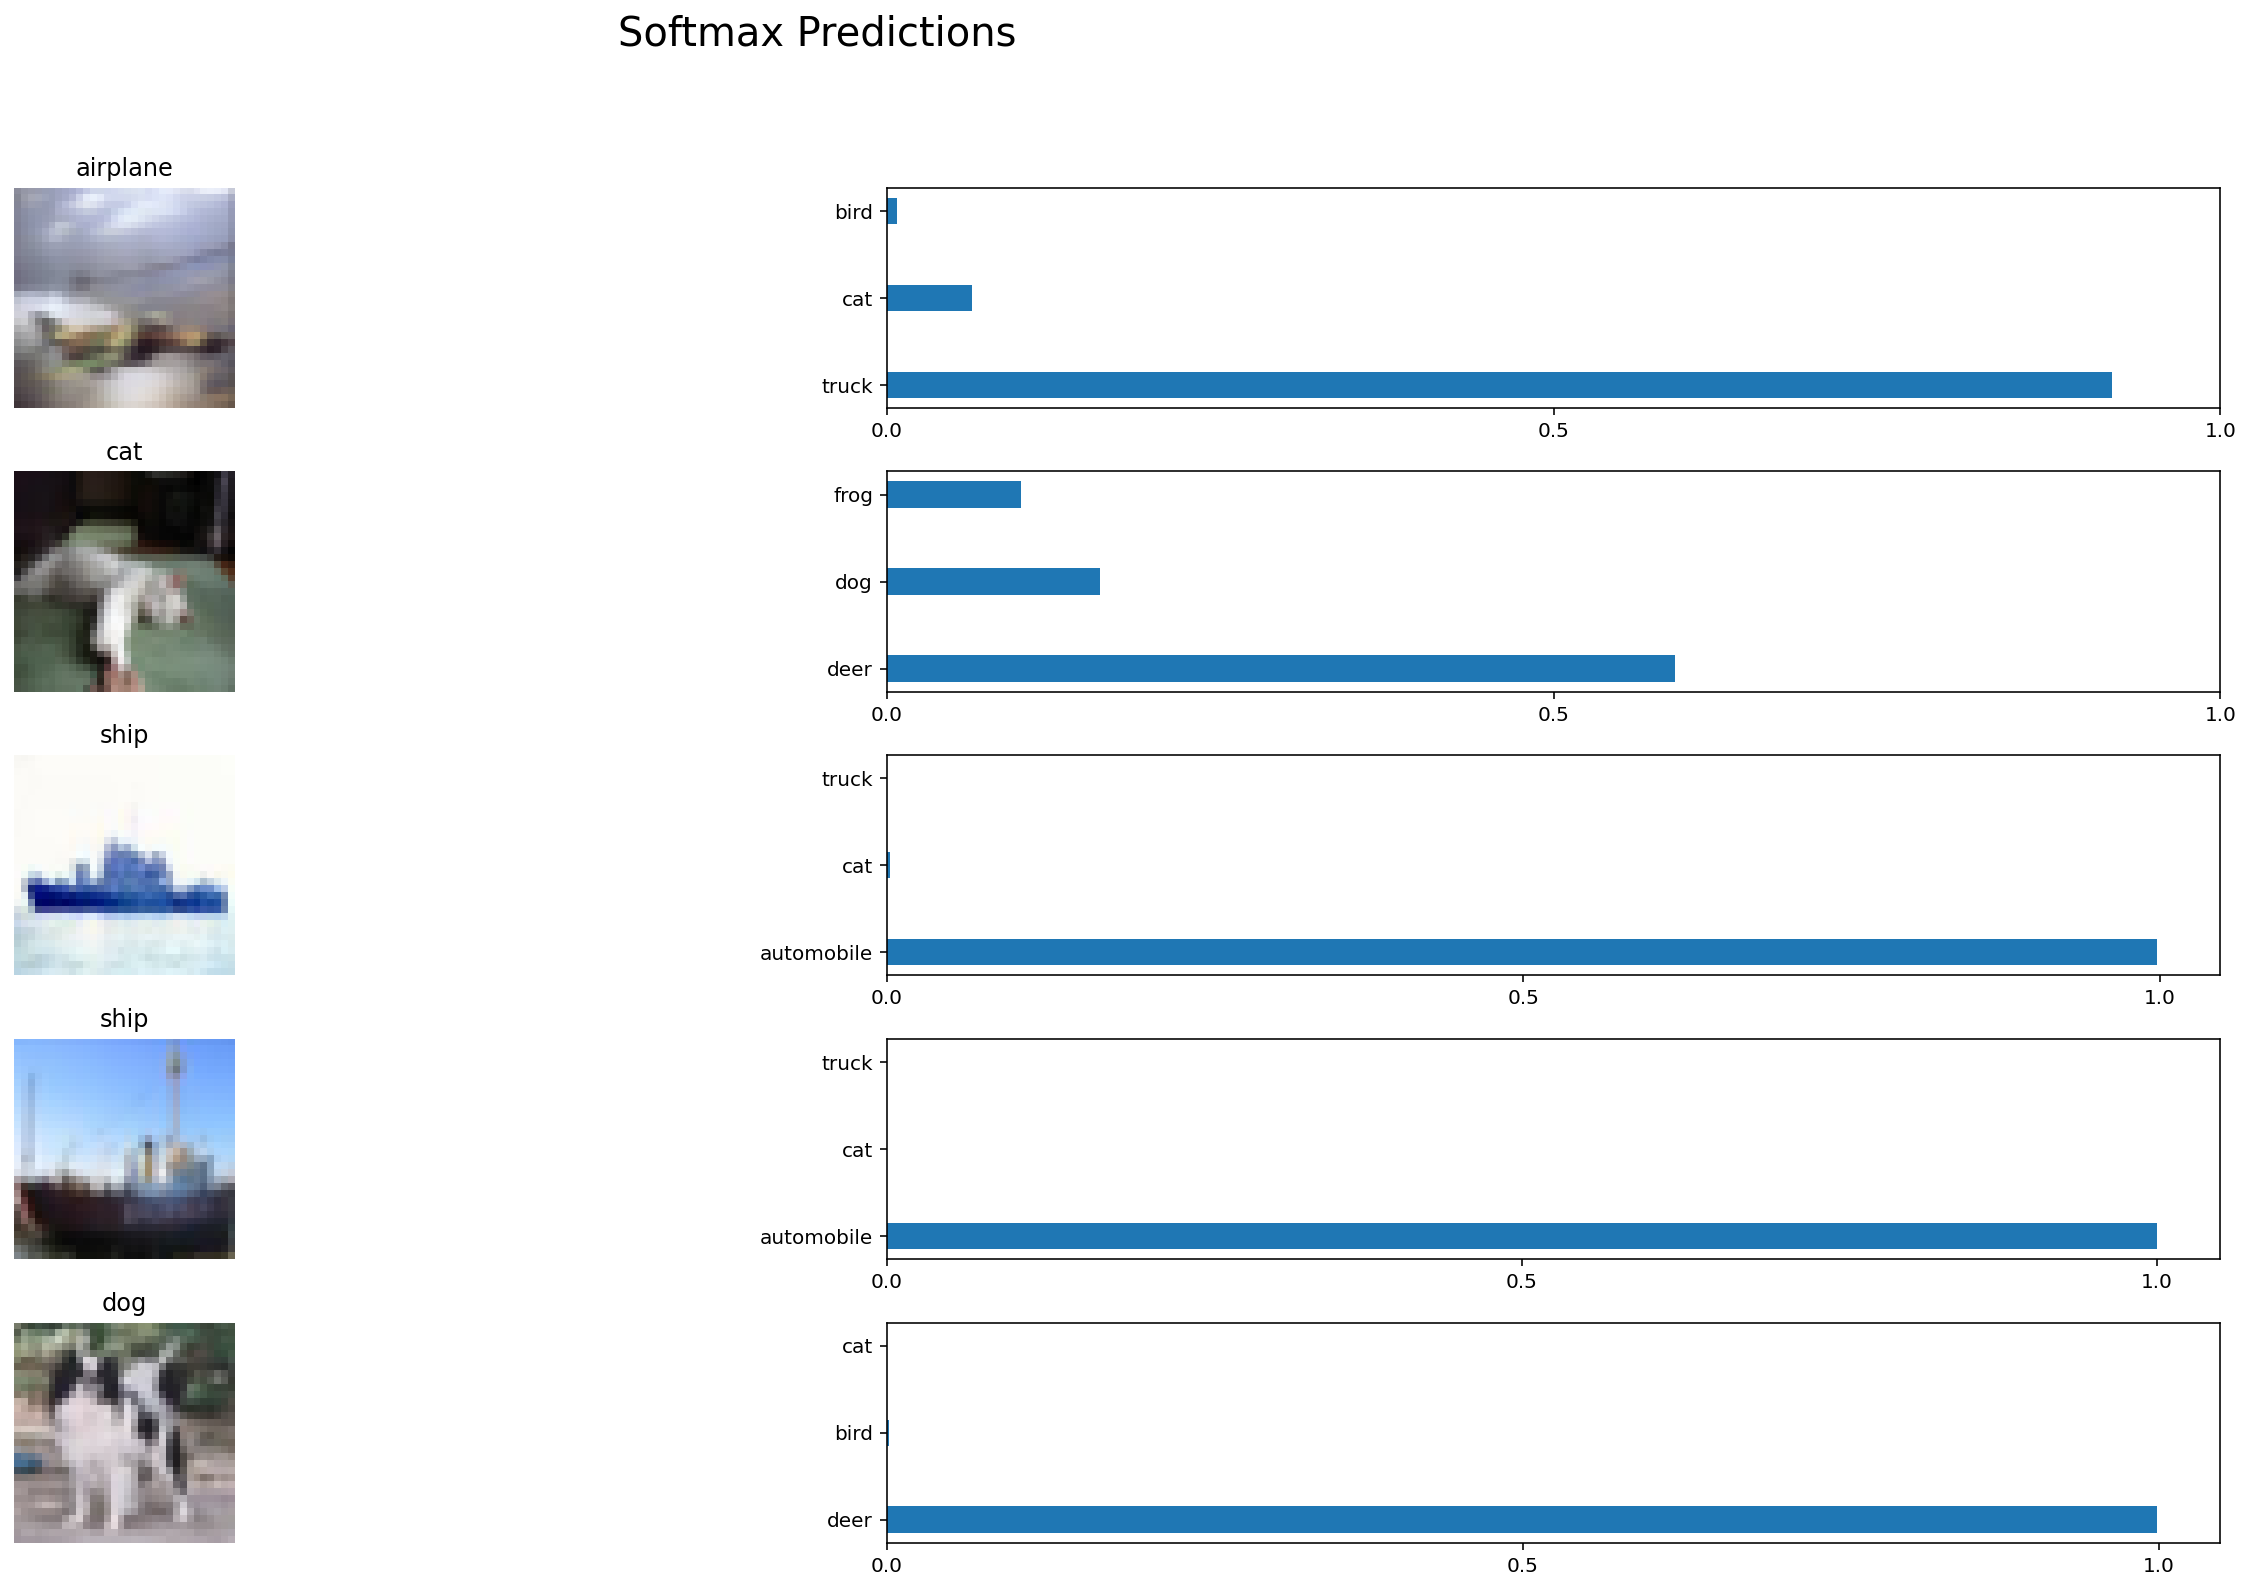

In [26]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import random

save_model_path = './image_classification'
batch_size = 64
n_samples = 10
top_n_predictions = 5

def test_model():
    test_features, test_labels = pickle.load(open('preprocess_training.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('input_x:0')
        loaded_y = loaded_graph.get_tensor_by_name('output_y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for train_feature_batch, train_label_batch in batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: train_feature_batch, loaded_y: train_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        display_image_predictions(random_test_features, random_test_labels, random_test_predictions, top_n_predictions)


test_model()

## Other Models & their Accuracies 
[Classification datasets results - well above 70%](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130)